In [1]:
# Link to the Kaggle Competition: https://www.kaggle.com/competitions/titanic

In [2]:
# Importing Relevant Libraries
import pandas as pd
import numpy as np
import random as rnd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

# Different ML Models that are going to be used:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import accuracy_score # Metric to analye accuracy of model

# Used for setting up training and test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest # Used for outlier detection Method
from sklearn.impute import SimpleImputer # Used for Imputation of NaNs



In [3]:
encoder = LabelEncoder()
scaler = StandardScaler()

In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
data_combined = [train_data, test_data]

In [5]:
# There are different methods for outlier detection, some of which being :

      # IQR Method (Turkey):
          # Resistant to extreme values (Above/Below 1.5 IQR)
      # SD Method :
          # Resistant to extremeve values (Above/Below 2 SD)
          # Effective for Normally Distributed Data
      # Z-score Method:
          # Resistant to extreme values (Above/Below 3 Z-score)
          # Similar to SD Method
          # Effective for Normally Distributed Data
      # Modified Z Score Method
          # Similar to Z-Score Method but uses MAD (Mean Absolute Deviation) over Mean & SD
          # More suitable for smaller datasets
          # More robust than Z-Score Method
      # Isolation Forest
          # Effective for High Dimensional Datasets
          # Handles both Normal and Skewed Data effectively
          # Does not focus on distribution of data, but rather isolating singular anamolies
      # DBSCAN Method
          # Effective in datasets with noise and volatility clustering, commonly found in share prices


# For the purtpose of this Project, 2 outlier methods will be used and compared.
# IQR Method
# Isolation Forest


In [6]:
# IQR Method Outlier Detection Function

def iqr_outlier_method(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the IQR method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        q1 = np.percentile(df[col], 25) # Retrives value corrsponding to 1st Quartile
        # 3rd quartile (75%)
        q3 = np.percentile(df[col],75) # Retrieves value corresponding to 3rd Quartile
        # Interquartile range (IQR)
        iqr = q3 - q1

        outlier_val = df[(df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_val)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)

    outlier_list = []
    for k, v in outlier_indices.items():
      if v > n:
        outlier_list.append(k)


    return outlier_list

# detect outliers from Age, SibSp , Parch and Fare
drop_values = iqr_outlier_method(train_data,2,["Age","SibSp","Parch","Fare"])
train_data_iqr = train_data.drop(drop_values, axis = 0).reset_index(drop=True)

In [7]:
# The Isolation Forest Method of Outlier Detection does not account for NaNs
# This means that we have to either remove NaNs (Which isn't effective because a sizeable amount of data will be lost)
# Or we can do imputation, (impute the missing values)
# This only applies to Numerical Dtaa however, so a different method would be used on non numerical data

def impute_missing_values(df, strategy='median'):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    imputer = SimpleImputer(strategy=strategy)
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    return df

# Impute missing values in your DataFrame (only numeric columns)
train_data_imputed = impute_missing_values(train_data, strategy='median')



In [8]:
def isolation_forest_outlier_detection(df, features, contamination_factor=0.01):
    """
    Detects outliers in a dataframe using the Isolation Forest method.

    Args:
    df (DataFrame): The input dataframe.
    features (list): List of feature column names to be considered for outlier detection.
    contamination_factor (float): The proportion of outliers in the data set. Defaults to 1%.

    Returns:
    List: Indices of the outliers detected by the Isolation Forest.
    """
    # Selecting the relevant features
    df_features = df[features]

    # Creating the model
    iso_forest = IsolationForest(contamination=contamination_factor)

    # Fitting the model
    preds = iso_forest.fit_predict(df_features)

    # Outliers will have a prediction value of -1
    outlier_indices = df_features[preds == -1].index.tolist()

    return outlier_indices

outlier_indices = isolation_forest_outlier_detection(train_data, ["Age", "SibSp", "Parch", "Fare"])
train_data_IF = train_data.drop(outlier_indices, axis=0).reset_index(drop=True)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [9]:
# Apply the Isolation Forest method
outlier_indices = isolation_forest_outlier_detection(train_data_imputed, ["Age", "SibSp", "Parch", "Fare"])
train_data_IF = train_data_imputed.drop(outlier_indices, axis=0).reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [10]:
# We now have two data sets that we can run or models on :
    # train_data_iqr
    # train_data_IF

In [11]:
train_data_iqr.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
train_data_IF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S


In [13]:
train_data_iqr.info()
train_data_IF.info() # The IF dataset has 6 more entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  882 non-null    float64
 1   Survived

In [14]:
train_data_iqr.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
10%,91.000000,0.000000,1.000000,14.000000,0.000000,0.000000,7.550000
20%,180.000000,0.000000,1.000000,19.000000,0.000000,0.000000,7.854200
30%,270.000000,0.000000,2.000000,22.000000,0.000000,0.000000,8.050000
40%,360.000000,0.000000,2.000000,25.000000,0.000000,0.000000,10.500000
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
60%,536.000000,0.000000,3.000000,32.000000,0.000000,0.000000,21.000000


In [15]:
train_data_IF.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,446.137188,0.382086,2.317460,29.298379,0.515873,0.360544,29.499290
std,257.390221,0.486173,0.831496,13.007336,1.098073,0.755868,38.212721
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
10%,91.100000,0.000000,1.000000,16.000000,0.000000,0.000000,7.550000
20%,179.200000,0.000000,1.000000,20.000000,0.000000,0.000000,7.854200
30%,268.300000,0.000000,2.000000,24.000000,0.000000,0.000000,8.050000
40%,357.400000,0.000000,2.000000,28.000000,0.000000,0.000000,10.500000
50%,446.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
60%,534.600000,0.000000,3.000000,28.000000,0.000000,0.000000,21.000000


In [16]:
train_data_iqr.corr().sort_values(by="Survived")

<ipython-input-16-f9250945dd3d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data_iqr.corr().sort_values(by="Survived")


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Pclass,-0.042702,-0.334097,1.000000,-0.374495,0.065031,0.016440,-0.555558
Age,0.034172,-0.076867,-0.374495,1.000000,-0.307129,-0.186457,0.110219
PassengerId,1.000000,-0.003089,-0.042702,0.034172,-0.072042,0.004052,0.031211
SibSp,-0.072042,0.003330,0.065031,-0.307129,1.000000,0.379281,0.110072
Parch,0.004052,0.092819,0.016440,-0.186457,0.379281,1.000000,0.183801
Fare,0.031211,0.264613,-0.555558,0.110219,0.110072,0.183801,1.000000
Survived,-0.003089,1.000000,-0.334097,-0.076867,0.003330,0.092819,0.264613


In [17]:
train_data_IF.corr().sort_values(by="Survived")

<ipython-input-17-2c4cbc370eba>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data_IF.corr().sort_values(by="Survived")


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Pclass,-0.041057,-0.334089,1.000000,-0.343186,0.095172,0.027176,-0.615165
Age,0.029681,-0.062981,-0.343186,1.000000,-0.233193,-0.211498,0.099883
SibSp,-0.048921,-0.037951,0.095172,-0.233193,1.000000,0.429350,0.181092
PassengerId,1.000000,-0.004374,-0.041057,0.029681,-0.048921,-0.006766,0.020918
Parch,-0.006766,0.100375,0.027176,-0.211498,0.429350,1.000000,0.222223
Fare,0.020918,0.277810,-0.615165,0.099883,0.181092,0.222223,1.000000
Survived,-0.004374,1.000000,-0.334089,-0.062981,-0.037951,0.100375,0.277810


In [18]:
train_data_iqr.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<ipython-input-19-07fa1481951d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data_iqr.corr()


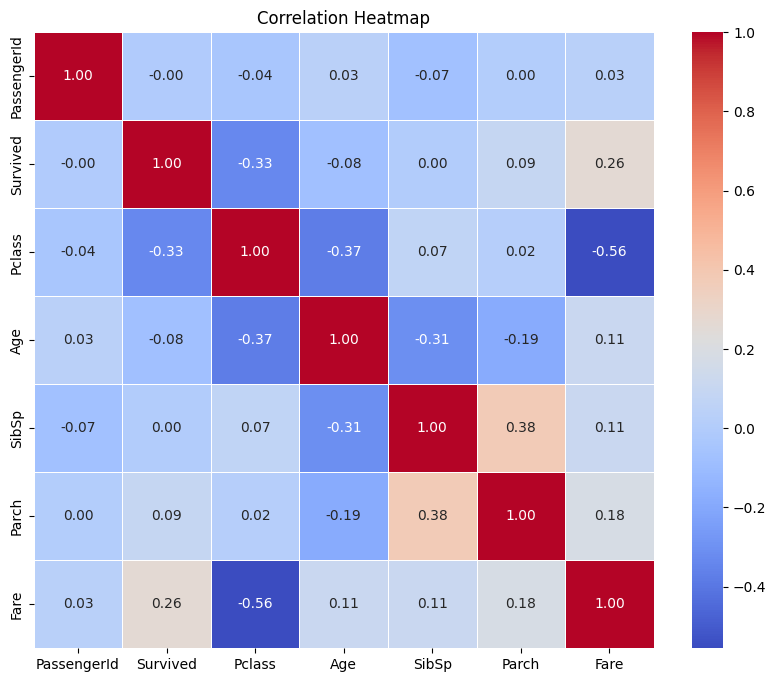

In [19]:
# Assuming train_data_iqr is your DataFrame
corr = train_data_iqr.corr()

# Setting up the matplotlib figure
plt.figure(figsize=(10, 8))

# Drawing the heatmap
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, # This will write the data value in each cell
            cmap='coolwarm', # Color scheme
            fmt='.2f', # Formatting the annotation to two decimal places
            linewidths=.5) # Space between cells

plt.title('Correlation Heatmap')
plt.show()

<ipython-input-20-613d281d0d99>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data_IF.corr()


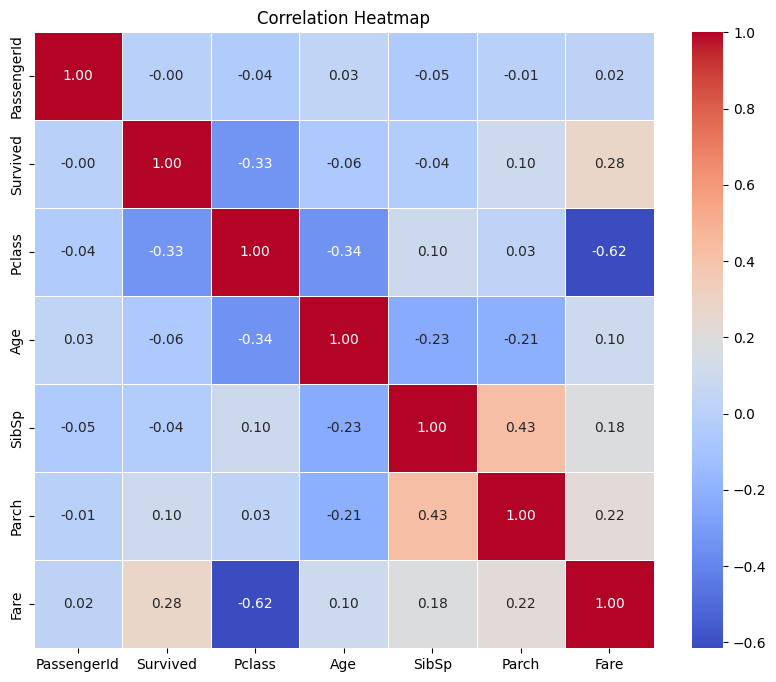

In [20]:
# Assuming train_data_iqr is your DataFrame
corr = train_data_IF.corr()

# Setting up the matplotlib figure
plt.figure(figsize=(10, 8))

# Drawing the heatmap
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, # This will write the data value in each cell
            cmap='coolwarm', # Color scheme
            fmt='.2f', # Formatting the annotation to two decimal places
            linewidths=.5) # Space between cells

plt.title('Correlation Heatmap')
plt.show()

In [21]:
# From the Corrlation Heatmaps, we see that PClass has a fairly strong correlation with Survided.
# We will group the data by PClass and then compare:

In [22]:
grouped_data = train_data_iqr.groupby('Pclass')['Survived'].mean().reset_index()
sorted_data = grouped_data.sort_values('Survived', ascending=False)
print(sorted_data)

   Pclass  Survived
0       1  0.629108
1       2  0.472826
2       3  0.245868


In [23]:
grouped_data = train_data_IF.groupby('Pclass')['Survived'].mean().reset_index()
sorted_data = grouped_data.sort_values('Survived', ascending=False)
print(sorted_data)

   Pclass  Survived
0     1.0  0.626794
1     2.0  0.472826
2     3.0  0.243354


In [24]:
# We see that the Survival Rate is heavily affected by the Passenger Class

In [25]:
# Now we see if gender has an effect
grouped_data = train_data_iqr.groupby('Sex')['Survived'].mean().reset_index()
sorted_data = grouped_data.sort_values('Survived', ascending=False)
print(sorted_data)

      Sex  Survived
0  female  0.747573
1    male  0.190559


In [26]:
grouped_data = train_data_IF.groupby('Sex')['Survived'].mean().reset_index()
sorted_data = grouped_data.sort_values('Survived', ascending=False)
print(sorted_data)

      Sex  Survived
0  female  0.744337
1    male  0.186736


In [27]:
# We see that Gender also has a huge effect on the survival rate

In [28]:
# Now wee see if the port the Passenger Embarked from has an effect
grouped_data = train_data_iqr.groupby('Embarked')['Survived'].mean().reset_index()
sorted_data = grouped_data.sort_values('Survived', ascending=False)
print(sorted_data)

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339117


In [29]:
grouped_data = train_data_IF.groupby('Embarked')['Survived'].mean().reset_index()
sorted_data = grouped_data.sort_values('Survived', ascending=False)
print(sorted_data)

  Embarked  Survived
0        C  0.545455
1        Q  0.389610
2        S  0.336991


In [30]:
# Passengers embarking from Port C were much more likely to live.

In [31]:
# Now we see iff the number of siblings on had affected the Survival Rate
grouped_data = train_data_iqr.groupby('SibSp')['Survived'].mean().reset_index()
sorted_data = grouped_data.sort_values('Survived', ascending=False)
print(sorted_data)

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
4      4  0.166667
3      3  0.153846
5      5  0.000000


In [32]:
grouped_data = train_data_IF.groupby('SibSp')['Survived'].mean().reset_index()
sorted_data = grouped_data.sort_values('Survived', ascending=False)
print(sorted_data)

   SibSp  Survived
1    1.0  0.541063
2    2.0  0.464286
0    0.0  0.342715
4    4.0  0.166667
3    3.0  0.153846
5    5.0  0.000000
6    8.0  0.000000


          FareBand  Survived
0  (-0.001, 7.896]  0.197309
1  (7.896, 14.454]  0.303571
2   (14.454, 30.5]  0.456221
3  (30.5, 512.329]  0.594470
          FareBand  Survived
0  (-0.001, 7.896]  0.197309
1  (7.896, 14.454]  0.303571
2   (14.454, 30.5]  0.456221
3  (30.5, 262.375]  0.577982


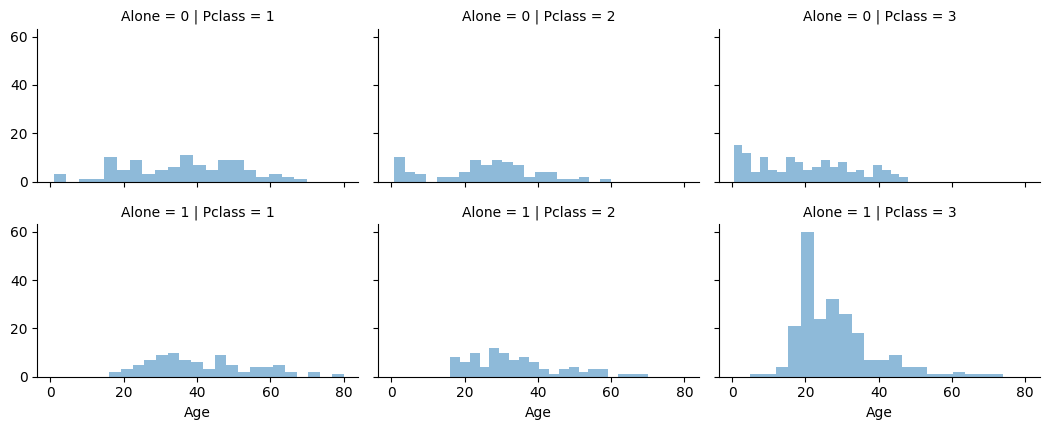

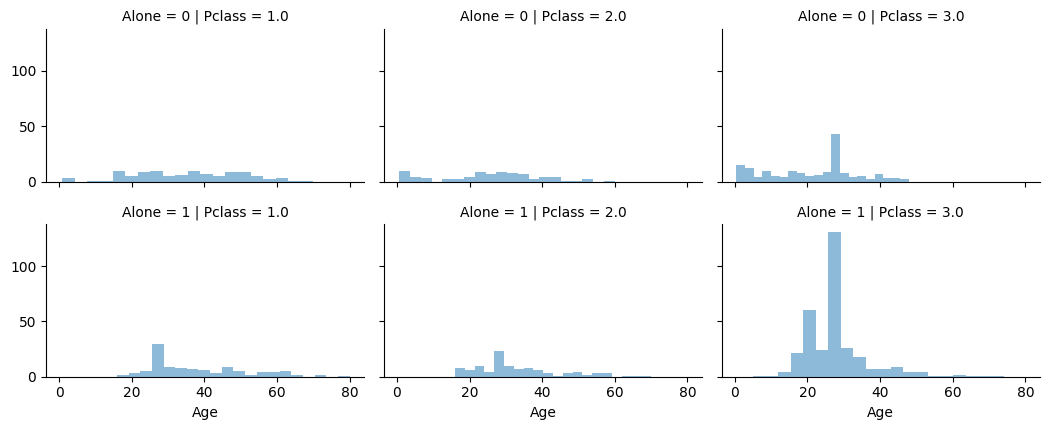

In [33]:
def preprocess_data(data, encoder):
    # Dropping unnecessary columns
    data = data.drop(["Cabin", "PassengerId", "Name", "Ticket"], axis=1)

    # Encoding 'Sex'
    data["Sex"] = encoder.fit_transform(data["Sex"])

    # Imputing 'Embarked' and 'Fare'
    freq_port = data["Embarked"].dropna().mode()[0]
    data["Embarked"] = data["Embarked"].fillna(freq_port)
    data["Fare"] = data["Fare"].fillna(data["Fare"].mean())
    data["Embarked"] = encoder.fit_transform(data["Embarked"])

    # Creating new features: 'Family Size' and 'Alone'
    data["Family Size"] = data["SibSp"] + data["Parch"] + 1
    data["Alone"] = 0
    data.loc[data["Family Size"] == 1, "Alone"] = 1
    data = data.drop(["Family Size", "SibSp", "Parch"], axis=1)

    # Handling 'Age' and 'Fare' Binning
    grid = sns.FacetGrid(data, col='Pclass', row='Alone', height=2.2, aspect=1.6)
    grid.map(plt.hist, 'Age', alpha=.5, bins=20)
    grid.add_legend()

    age_guess = np.zeros((data["Alone"].unique().size, data["Pclass"].unique().size))
    for i in range(age_guess.shape[0]):
        for j in range(age_guess.shape[1]):
            guess_df = data.loc[(data["Alone"] == i) & (data["Pclass"] == j + 1), "Age"].dropna()
            age_guess[i, j] = guess_df.mean()

    for i in range(age_guess.shape[0]):
        for j in range(age_guess.shape[1]):
            data.loc[(data["Age"].isnull()) & (data["Alone"] == i) & (data["Pclass"] == j + 1), "Age"] = age_guess[i, j]
    data["Age"] = np.round(data["Age"])

    data["AgeBand"] = pd.cut(data["Age"], 5)

    data.loc[data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[data['Age'] > 64, 'Age'] = 4

    data['FareBand'] = pd.qcut(data['Fare'], 4)
    #data = data.drop("FareBand", axis=1)
    print(data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True))

    data.loc[data['Fare'] <= 7.896, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.896) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 30.5), 'Fare'] = 2
    data.loc[data['Fare'] > 30.5, 'Fare'] = 3

    data = data.drop(["AgeBand", "FareBand"], axis = 1)

    return data

# Assuming encoder is defined and initialized
train_data_iqr = preprocess_data(train_data_iqr, encoder)
train_data_IF = preprocess_data(train_data_IF, encoder)


In [34]:
# Generating the Model for the IQR dataset first

In [35]:
X = train_data_iqr.drop("Survived", axis=1)
y = train_data_iqr["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.drop("PassengerId", axis=1)

Results for train_data_iqr:
LogisticRegression(max_iter=1000)
Logistic Regression - Validation Accuracy: 0.79, Training Accuracy: 0.80
SVC(C=0.9, gamma=0.2)
SVC - Validation Accuracy: 0.81, Training Accuracy: 0.83
KNeighborsClassifier(n_neighbors=3)
KNN - Validation Accuracy: 0.79, Training Accuracy: 0.84
DecisionTreeClassifier(criterion='entropy', max_depth=3)
Decision Tree - Validation Accuracy: 0.79, Training Accuracy: 0.81
GradientBoostingClassifier()
Gradient Boosting - Validation Accuracy: 0.79, Training Accuracy: 0.84
AdaBoostClassifier(learning_rate=1)
AdaBoost - Validation Accuracy: 0.77, Training Accuracy: 0.80
RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50)
Random Forest - Validation Accuracy: 0.81, Training Accuracy: 0.83

Results for train_data_IF:
LogisticRegression(max_iter=1000)
Logistic Regression - Validation Accuracy: 0.79, Training Accuracy: 0.79
SVC(C=0.9, gamma=0.2)
SVC - Validation Accuracy: 0.83, Training Accuracy: 0.81
KNeighborsClassi

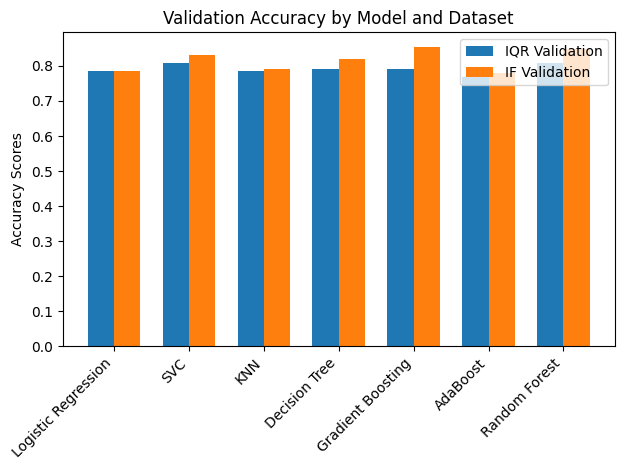

In [41]:
def train_and_evaluate_models(data, test_data):
    # Preparing the data
    X = data.drop("Survived", axis=1)
    y = data["Survived"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_test = test_data.drop("PassengerId", axis=1)

    models = {
        "Logistic Regression": LogisticRegression(solver="lbfgs", max_iter=1000),
        "SVC": SVC(kernel="rbf", C=0.9, gamma=0.2),
        "KNN": KNeighborsClassifier(n_neighbors=3),
        "Decision Tree": DecisionTreeClassifier(max_depth=3, criterion="entropy"),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
        "AdaBoost": AdaBoostClassifier(n_estimators=50, learning_rate=1),
        "Random Forest": RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5)  # Keep this as last model

    }

    results = {}

    for name, model in models.items():
        print(model)
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        train_pred = model.predict(X_train)
        val_accuracy = accuracy_score(val_pred, y_val)
        train_accuracy = accuracy_score(train_pred, y_train)
        results[name] = (val_accuracy, train_accuracy)
        print(f"{name} - Validation Accuracy: {val_accuracy:.2f}, Training Accuracy: {train_accuracy:.2f}")

    return results

# Train and evaluate models on both datasets
print("Results for train_data_iqr:")
results_iqr = train_and_evaluate_models(train_data_iqr, test_data)

print("\nResults for train_data_IF:")
results_IF = train_and_evaluate_models(train_data_IF, test_data)

# Plotting the results
labels = list(results_iqr.keys())
iqr_val_scores = [score[0] for score in results_iqr.values()]
IF_val_scores = [score[0] for score in results_IF.values()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, iqr_val_scores, width, label='IQR Validation')
rects2 = ax.bar(x + width/2, IF_val_scores, width, label='IF Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Scores')
ax.set_title('Validation Accuracy by Model and Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")  # Rotate labels to prevent overlap
ax.legend()

plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [42]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_models(data, test_data, test_data_passenger_ids):
    X = data.drop("Survived", axis=1)
    y = data["Survived"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_test = test_data

    models = {
        "Logistic Regression": LogisticRegression(solver="lbfgs", max_iter=1000),
        "SVC": SVC(kernel="rbf", C=0.9, gamma=0.2),
        "KNN": KNeighborsClassifier(n_neighbors=3),
        "Decision Tree": DecisionTreeClassifier(max_depth=3, criterion="entropy"),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
        "AdaBoost": AdaBoostClassifier(n_estimators=50, learning_rate=1),
        "Random Forest": RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        train_pred = model.predict(X_train)
        val_accuracy = accuracy_score(val_pred, y_val)
        train_accuracy = accuracy_score(train_pred, y_train)
        results[name] = (val_accuracy, train_accuracy)
        print(f"{name} - Validation Accuracy: {val_accuracy:.2f}, Training Accuracy: {train_accuracy:.2f}")


        #train_pred.to_csv(f'submission_{name.replace(" ", "_")}.csv', index=False)
        np.savetxt("my_array.csv",train_pred, delimiter=",")


    return results

# Extract PassengerId before any preprocessing
test_data_passenger_ids = test_data['PassengerId']

# Assuming train_data_iqr and train_data_IF are already defined and preprocessed
print("Results for train_data_iqr:")
results_iqr = train_and_evaluate_models(train_data_iqr, test_data, test_data_passenger_ids)

print("\nResults for train_data_IF:")
results_IF = train_and_evaluate_models(train_data_IF, test_data, test_data_passenger_ids)

# Plotting code remains the same...


Results for train_data_iqr:
Logistic Regression - Validation Accuracy: 0.79, Training Accuracy: 0.80
SVC - Validation Accuracy: 0.81, Training Accuracy: 0.83
KNN - Validation Accuracy: 0.79, Training Accuracy: 0.84
Decision Tree - Validation Accuracy: 0.79, Training Accuracy: 0.81
Gradient Boosting - Validation Accuracy: 0.79, Training Accuracy: 0.84
AdaBoost - Validation Accuracy: 0.77, Training Accuracy: 0.80
Random Forest - Validation Accuracy: 0.82, Training Accuracy: 0.83

Results for train_data_IF:
Logistic Regression - Validation Accuracy: 0.79, Training Accuracy: 0.79
SVC - Validation Accuracy: 0.83, Training Accuracy: 0.81
KNN - Validation Accuracy: 0.79, Training Accuracy: 0.81
Decision Tree - Validation Accuracy: 0.82, Training Accuracy: 0.80
Gradient Boosting - Validation Accuracy: 0.85, Training Accuracy: 0.84
AdaBoost - Validation Accuracy: 0.78, Training Accuracy: 0.79
Random Forest - Validation Accuracy: 0.84, Training Accuracy: 0.83


In [43]:
def print_best_model(results, dataset_name):
    best_model = max(results, key=lambda x: results[x][0])  # Find the model with the highest validation accuracy
    best_score = results[best_model][0]  # Validation accuracy of the best model
    print(f"Best model for {dataset_name}: {best_model} with Validation Accuracy: {best_score:.2f}")

# Assuming results_iqr and results_IF contain the results for train_data_iqr and train_data_IF datasets respectively
print_best_model(results_iqr, "train_data_iqr")
print_best_model(results_IF, "train_data_IF")


Best model for train_data_iqr: Random Forest with Validation Accuracy: 0.82
Best model for train_data_IF: Gradient Boosting with Validation Accuracy: 0.85
